In [2]:
# workaround if you have not yet installed CherenkovDeconvolution.py but want to try it from this notebook
import sys
sys.path.insert(0,'/net/nfshome/home/shaefs/CherenkovDeconvolution.py')

In [3]:
from cherenkovdeconvolution import dsea
import cherenkovdeconvolution.stepsize as stepsize

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import pandas as pd

In [4]:
# Feature Selection
feature_list = ['SplineMPEDirectHitsICE.n_dir_doms', 
                        'VariousVariables.Cone_Angle',
                        'SplineMPECramerRaoParams.variance_theta',
                        'Borderness.Q_ratio_in_border',
                        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
                        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
                        'SplineMPEDirectHitsICB.n_late_doms',
                        'Dustyness.n_doms_in_dust',
                        'LineFitGeoSplit1Params.n_hits',
                        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
                        'SPEFit2GeoSplit1BayesianFitParams.logl',
                        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']

In [5]:
fields = feature_list + ['MCPrimary.energy']

In [6]:
# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)

df_raw

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [7]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

# Discretize the target Neutrino Energy

In [8]:
# discretize
df['MCPrimary.energy'].describe()

count    1.333639e+07
mean     6.298949e+03
std      2.457562e+05
min      1.000001e+02
25%      2.706783e+02
50%      5.471676e+02
75%      1.416143e+03
max      9.970067e+07
Name: MCPrimary.energy, dtype: float64

In [9]:
# Variables: Label
# drop out all events with Energies outside the range
lower_limit = 100
upper_limit = 10**5

# Variables: NN
num_bins = 10 # number of bins (energy classes), output_shape

In [10]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<upper_limit) & (df['MCPrimary.energy']>lower_limit)]
df

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [11]:
## log-scaled Binning
bins = np.logspace(np.log10(lower_limit), np.log10(upper_limit), num_bins+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [12]:
# # Equal-frequency Binning

# #define function to calculate equal-frequency bins 
# def equalObs(x, nbin):
#     nlen = len(x)
#     return np.interp(np.linspace(0, nlen, nbin + 1),
#                      np.arange(nlen),
#                      np.sort(x))

# #create histogram with equal-frequency bins 
# n, bins, patches = plt.hist(df['MCPrimary.energy'].to_numpy(), equalObs(df['MCPrimary.energy'].to_numpy(), num_bins), edgecolor='black')
# plt.show()

# #display bin boundaries and frequency per bin 
# bins, n

In [13]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [14]:
# one hot encoded vector (necessary for cce)
df_E_dummie = pd.get_dummies(df['E_discr'])
df_E_dummie

E_discr,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13336408,0,0,0,0,1,0,0,0,0,0
13336409,0,0,0,0,1,0,0,0,0,0
13336410,0,0,1,0,0,0,0,0,0,0
13336411,0,1,0,0,0,0,0,0,0,0


In [15]:
# target
y = df_E_dummie.to_numpy()
y.shape

(13262094, 10)

In [16]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 12)

In [17]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    perm = np.random.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [18]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.2, subset=0)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(10609675, 12) (10609675, 10) (2652419, 12) (2652419, 10)


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

# DSEA: Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB

In [21]:
f_est = dsea(X_eval, X_train, y_train_cls, GaussianNB(), K=7)
f_est

array([4.62436742e-02, 3.58948126e-04, 1.33643070e-07, 6.95719509e-01,
       1.64791926e-01, 3.53775085e-02, 1.70033390e-02, 2.84519761e-03,
       2.73014849e-02, 1.03582785e-02])

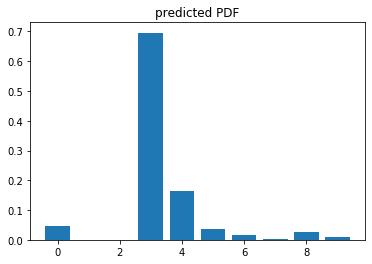

In [22]:
plt.bar(np.arange(len(f_est)), f_est)
plt.title('predicted pdf')
None

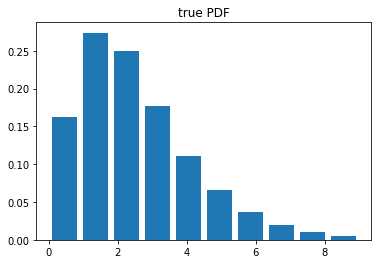

In [23]:
plt.hist(y_eval_cls, histtype='bar', density=True, rwidth=0.8)
plt.title('true pdf')
None

# DSEA: Naive Bayes with stepsize

In [23]:
# first of all, we set up an inspection function, which prints the step size of each iteration
def inspect_alpha(k, alpha, chi2s, f): # you can define custom inspection methods to investigate DSEA
    print(alpha)

In [24]:
# The other one decays exponentially, which is rather fast
alpha_exp = stepsize.decay_exp(0.5, 2.0) # start with step size 2
f_est_exp = dsea(X_eval, X_train, y_train_cls, GaussianNB(), K = 3, inspect = inspect_alpha,  alpha = alpha_exp)

0
1
2


<BarContainer object of 10 artists>

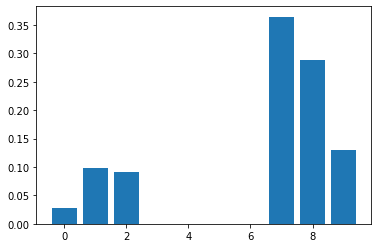

In [25]:
plt.bar(np.arange(len(f_est_exp)), f_est_exp)

# DSEA: Naive Bayes with adaptive stepsize

In [32]:
from cherenkovdeconvolution.discretize import TreeDiscretizer
discretizer = TreeDiscretizer(X_train, y_train_cls, 4) # interpret the 4 leaves of a decision tree as clusters
x_data  = discretizer.discretize(X_eval)
x_train = discretizer.discretize(X_train)
alpha = stepsize.alpha_adaptive_run(x_data, x_train, y_train_cls, tau = 0, bins_y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) # a function object like above

# inspect the chosen alpha values with a callback function
def inspect_alpha(f, k, a, chi2s): # this signature is mandatory. Here, f is the latest estimate.
    print('Iteration {}: alpha = {}'.format(k, a)) # print iteration number and alpha value

# deconvolve
f_est = dsea(X_eval, X_train, y_train_cls, GaussianNB(), K = 6, alpha = alpha, inspect = inspect_alpha)
#print('Chi square distance between f_est and f_true: {}'.format(util.chi2s(f_est, f_true)))
f_est # Chi square distance of single-iteration DSEA was 0.001396749429286623

Iteration 0: alpha = nan
Iteration 1: alpha = 3.2832434933237817e-16
Iteration 2: alpha = 1.5949088247228786e-209
Iteration 3: alpha = 1.5949088247228786e-209
Iteration 4: alpha = 1.5949088247228786e-209
Iteration 5: alpha = 1.5949088247228786e-209
Iteration 6: alpha = 1.5949088247228786e-209


array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

<BarContainer object of 10 artists>

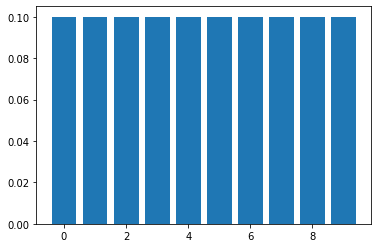

In [34]:
plt.bar(np.arange(len(f_est)), f_est)


# DSEA: Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
# from one-hot encoded vector label to integer
y_train_cls = np.argmax(y_train, axis=1)
y_eval_cls = np.argmax(y_eval, axis=1)
np.unique(y_train_cls)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
f_est = dsea(X_eval, X_train, y_train_cls, RandomForestClassifier(max_depth=3, random_state=0), K=3)
f_est

/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KeyboardInterrupt: 

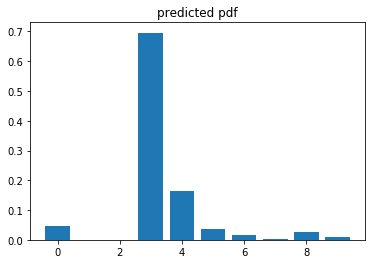

In [24]:
plt.bar(np.arange(len(f_est)), f_est)
plt.title('predicted pdf')
None

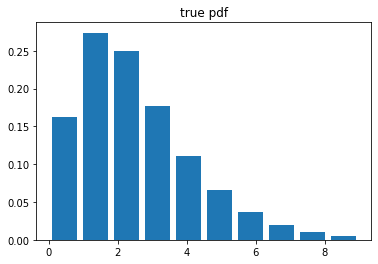

In [25]:
plt.hist(y_eval_cls, histtype='bar', density=True, rwidth=0.8)
plt.title('true pdf')
None

# DSEA: Random Forest with exp. stepsize

In [24]:
# first of all, we set up an inspection function, which prints the step size of each iteration
def inspect_alpha(k, alpha, chi2s, f): # you can define custom inspection methods to investigate DSEA
    print(alpha)

In [25]:
alpha_exp = stepsize.decay_exp(0.5, 2.0) # start with step size 2
f_est_exp = dsea(X_eval, X_train, y_train_cls, RandomForestClassifier(), K = 3, inspect = inspect_alpha,  alpha = alpha_exp)

0


/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1
2
3


In [29]:
_, f_true = np.unique(y_eval_cls, return_counts=True)
f_true = f_true/len(y_eval_cls)
f_true

array([0.14649345, 0.24617641, 0.22407697, 0.15901749, 0.10013124,
       0.05837388, 0.0328108 , 0.01811742, 0.00967758, 0.00512476])

In [30]:
f_est_exp

array([0.14500684, 0.24315566, 0.22268841, 0.16008516, 0.10211212,
       0.06026018, 0.03283041, 0.01839397, 0.01001941, 0.00544783])

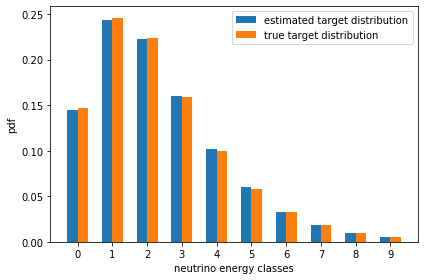

In [31]:
%matplotlib inline

# prepare plot
fig, ax = plt.subplots()
index = np.arange(10)
barwidth = .3

# add bar plots
ax.bar(index,            f_est_exp,  barwidth, label='estimated target distribution')
ax.bar(index + barwidth, f_true, barwidth, label='true target distribution')
ax.legend()

# show plot
plt.xticks(index + barwidth / 2, range(10))
plt.xlabel('neutrino energy classes')
plt.ylabel('pdf')

plt.tight_layout()
plt.savefig('output/pdf_dsea_randomforest2.pdf')
plt.show()

# 
# Looks good, huh?  :)
# 
